<a href="https://colab.research.google.com/github/DaSalm/NetologyHW/blob/master/Copy_of_006_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [4]:

# Upload kaggle API key file
uploaded = files.upload()

MessageError: ignored

In [5]:
! ls

 cats-dogs-vgg16.hdf5   sample_data	        test	   train.zip
'kaggle (1).json'       sample_submission.csv   test.zip
 kaggle.json	        submit.txt	        train


In [0]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [0]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

In [0]:
!unzip train.zip
!unzip test.zip

In [0]:
# !ls /content/

In [0]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [0]:
import re
from random import shuffle
from glob import glob

train_files = glob('../content/train/*.jpg')
test_files = glob('../content/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

---



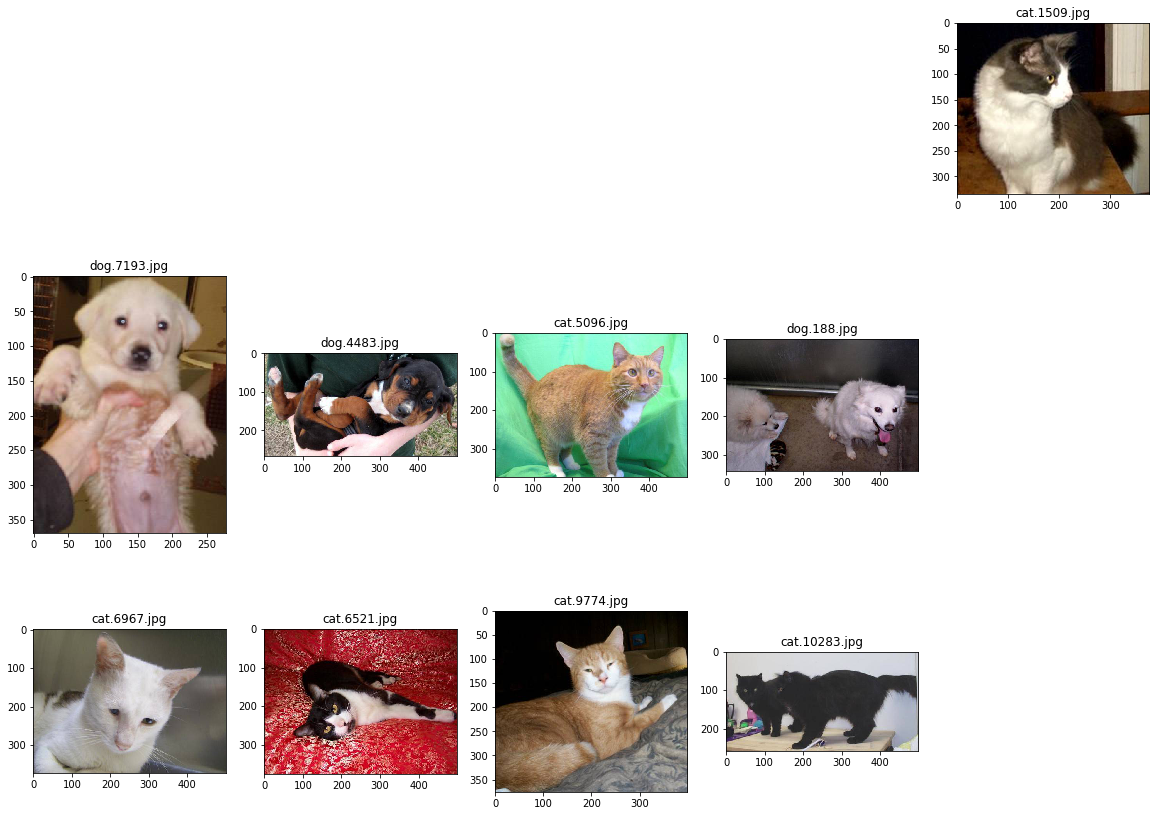

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[1:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [0]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [0]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [71]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [0]:
x = base_model.layers[-1].output # добавить к последнему слою
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x) # добавить нормализацию
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [81]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Компилируем модель и запускаем обучение

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [83]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 2s 233ms/step - loss: 0.3430 - acc: 0.8500 - val_loss: 0.7749 - val_acc: 0.8500
Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 0.2302 - acc: 0.9125 - val_loss: 0.3702 - val_acc: 0.9200
Epoch 3/100
10/10 [==============================] - 1s 111ms/step - loss: 0.1196 - acc: 0.9594 - val_loss: 0.4065 - val_acc: 0.9600
Epoch 4/100
10/10 [==============================] - 1s 108ms/step - loss: 0.1321 - acc: 0.9594 - val_loss: 0.3471 - val_acc: 0.9700
Epoch 5/100
10/10 [==============================] - 1s 113ms/step - loss: 0.1570 - acc: 0.9469 - val_loss: 0.4431 - val_acc: 0.9500
Epoch 6/100
10/10 [==============================] - 1s 125ms/step - loss: 0.1769 - acc: 0.9469 - val_loss: 0.4042 - val_acc: 0.9400
Epoch 7/100
10/10 [==============================] - 1s 128ms/step - loss: 0.1216 - acc: 0.9594 - val_loss: 0.2821 - val_acc: 0.9700
Epoch 8/100
10/10 [==============================] - 1s 123ms/step - 

In [0]:
model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [0]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

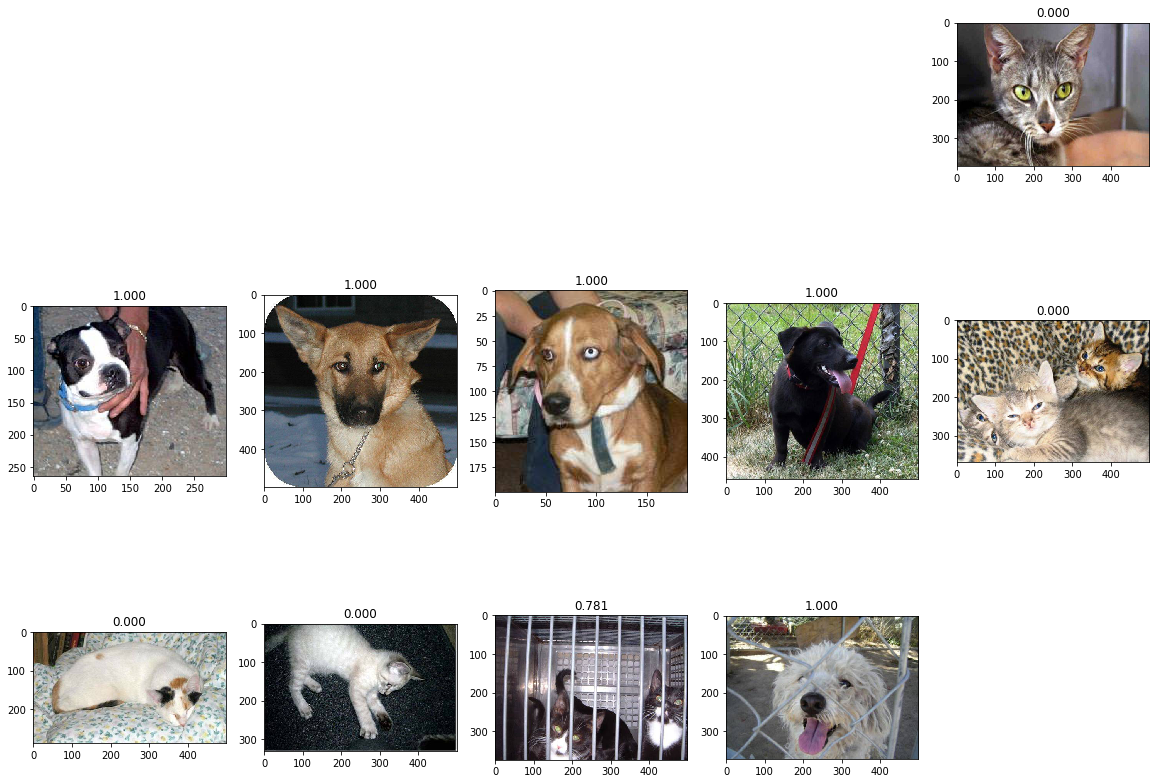

In [90]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [0]:
with open('submit3.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [0]:
# LogLoss
# train  0.1055
# test 0.2551

In [88]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'submit': 'submit3.txt'})
uploaded.SetContentFile('submit3.txt')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1P5dKSaj9ASNXhRhOKk53aRKDpXHYK0mQ
